## Modelo *Sequence-to-Sequence* para Predicción Multipasos en Series de Tiempo

Un modelo *sequence-to-sequence* (Seq2Seq) consiste en dos redes neuronales recurrentes:
un **codificador (encoder)** y un **decodificador (decoder)**.
El objetivo es mapear una secuencia de entrada de valores temporales hacia una secuencia de predicciones futuras.

### Secuencias de Entrada y Salida

Sea la secuencia de entrada:

$$
\mathbf{x} = (x_1, x_2, \ldots, x_T)
$$

El modelo debe predecir los siguientes $H$ pasos:

$$
\mathbf{y} = (y_1, y_2, \ldots, y_K)
$$

donde $T$ es la longitud de la ventana observada y $K$ es el horizonte de predicción.

### Codificador (*Encoder*)

El codificador es una red recurrente (por ejemplo, RNN, LSTM, GRU) que lee la secuencia de entrada paso a paso y produce una secuencia de estados ocultos:

$$
H_t = f_{\theta}(x_t, H_{t-1}) = \phi( W_x x_t + W_H H_{t-1} + b_H )
$$

El estado oculto final resume toda la secuencia de entrada:

$$
H_T = \text{Encoder}(\mathbf{x})
$$

Este vector $H_T$ se conoce como **vector de contexto** o **representación latente**. 


<center><img src="https://d2l.ai/_images/rnn.svg"/></center>



[Referencia](https://d2l.ai/chapter_recurrent-modern/lstm.html)

## Decodificador (*Decoder*)

El decodificador es otra RNN que genera los valores futuros de manera autorregresiva.
Se inicializa con el estado final del codificador:

$$
S_0 = H_T
$$

En cada futuro paso temporal $\tau$, el decodificador usa su salida previa como entrada:

$$
S_{\tau} = g(y_{\tau-1}, S_{\tau-1}) = \phi( W_y y_{\tau} + W_S S_{\tau-1} + b_S )
$$

Normalmente, una capa *Dense* mapea $S_{\tau}$ al valor predicho:

$$
\hat{y_{\tau}} = W S_{\tau} + b
$$

### Objetivo de Entrenamiento

El modelo minimiza el error cuadrático medio (MSE) entre la secuencia predicha y la secuencia futura real:

$$
\mathcal{L}(\theta, \phi)
= \frac{1}{H} \sum_{\tau=1}^{H}
(y_{\tau} - \hat{y}_{\tau})^2
$$


# Librerias

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

# Ejemplo

In [2]:
INPUT_LEN = 30
OUTPUT_LEN = 10
BATCH_SIZE = 64
HIDDEN_UNITS = 64
EPOCHS = 20
LR = 1e-3

# Datos Sintéticos

In [3]:
def make_sine_dataset(n_series=800, series_len=400):
    xs = []
    for i in range(n_series):
        t = np.arange(series_len)
        s = np.sin(0.02 * t) + np.random.normal(0, 0.05, series_len)
        xs.append(s)
    return np.array(xs)

def make_windows(series_array, input_len, output_len, stride=1):
    X_enc, Y_dec = [], []
    for s in series_array:
        for start in range(0, len(s) - input_len - output_len + 1, stride):
            X_enc.append(s[start:start+input_len])
            Y_dec.append(s[start+input_len:start+input_len+output_len])
    return np.expand_dims(X_enc, -1), np.expand_dims(Y_dec, -1)

# Encoder & Decoder

In [4]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.rnn = layers.SimpleRNN(units, return_state=True)

    def call(self, x):
        _, h = self.rnn(x)
        return h  

class Decoder(tf.keras.layers.Layer):
    def __init__(self, units, output_dim=1):
        super().__init__()
        self.cell = layers.SimpleRNNCell(units)
        self.rnn = layers.RNN(self.cell, return_sequences=True, return_state=True)
        self.dense = layers.Dense(output_dim)

    def call(self, x, initial_state):
        seq, h = self.rnn(x, initial_state=[initial_state])
        out = self.dense(seq)
        return out, h

# Modelo Seq2Seq

In [5]:
class Seq2Seq(tf.keras.Model):
    def __init__(self, units):
        super().__init__()
        self.encoder = Encoder(units)
        self.decoder = Decoder(units)

    def call(self, encoder_inputs, decoder_inputs=None, training=False):
        h = self.encoder(encoder_inputs)

        if training:
            outputs, _ = self.decoder(decoder_inputs, initial_state=h)
            return outputs

        outputs = []
        last = tf.expand_dims(encoder_inputs[:, -1, :], 1)

        for t in range(OUTPUT_LEN):
            out, h = self.decoder(last, initial_state=h)
            outputs.append(out)
            last = out

        return tf.concat(outputs, axis=1)

In [6]:
series = make_sine_dataset()
series

array([[-0.00566089,  0.08068254,  0.0376363 , ...,  0.97498643,
         1.01988892,  1.06283879],
       [-0.04571413,  0.04066307,  0.04358384, ...,  1.05239829,
         0.99458846,  1.0433106 ],
       [-0.10269401,  0.07756792,  0.04850468, ...,  1.00862981,
         1.01739746,  0.93586319],
       ...,
       [-0.0122671 ,  0.04363933,  0.1057908 , ...,  0.9951378 ,
         1.05150614,  0.94728572],
       [-0.01516527,  0.01822777,  0.0563554 , ...,  0.90434142,
         0.97924789,  1.07170622],
       [-0.00415353,  0.05686506,  0.10328603, ...,  0.98465055,
         0.93643403,  1.00721646]])

In [7]:
series.shape

(800, 400)

In [8]:
X, Y = make_windows(series, INPUT_LEN, OUTPUT_LEN, stride=3)

In [9]:
print(X.shape, Y.shape)

(96800, 30, 1) (96800, 10, 1)


In [10]:
split = int(len(X) * 0.8)
X_train, Y_train = X[:split], Y[:split]
X_val, Y_val = X[split:], Y[split:]

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(BATCH_SIZE)

2025-12-11 17:55:19.979648: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-12-11 17:55:19.979676: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-11 17:55:19.979683: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-11 17:55:19.979713: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-11 17:55:19.979728: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Entrenamiento

In [12]:
model = Seq2Seq(HIDDEN_UNITS)
opt = tf.keras.optimizers.legacy.Adam(LR)
loss_fn = tf.keras.losses.MeanSquaredError()

In [13]:
@tf.function
def train_step(enc_inp, dec_target):
    start = tf.expand_dims(enc_inp[:, -1, :], 1)
    dec_inp = tf.concat([start, dec_target[:, :-1, :]], axis = 1)
    
    with tf.GradientTape() as tape:
        preds = model(enc_inp, decoder_inputs = dec_inp, training = True)
        loss = loss_fn(dec_target, preds)
        
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [14]:
for epoch in range(EPOCHS):
    t_losses = []
    for xb, yb in train_ds:
        t_losses.append(train_step(xb, yb).numpy())

    v_losses = []
    for xb, yb in val_ds:
        preds = model(xb, training=False)
        v_losses.append(loss_fn(yb, preds).numpy())

    print(f"Epoch {epoch+1} - train: {np.mean(t_losses):.4f}  val: {np.mean(v_losses):.4f}")

2025-12-11 17:55:21.502095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1 - train: 0.0049  val: 0.0037
Epoch 2 - train: 0.0031  val: 0.0035
Epoch 3 - train: 0.0029  val: 0.0036
Epoch 4 - train: 0.0029  val: 0.0039
Epoch 5 - train: 0.0029  val: 0.0039
Epoch 6 - train: 0.0028  val: 0.0037
Epoch 7 - train: 0.0028  val: 0.0032
Epoch 8 - train: 0.0028  val: 0.0031
Epoch 9 - train: 0.0028  val: 0.0031
Epoch 10 - train: 0.0028  val: 0.0029
Epoch 11 - train: 0.0028  val: 0.0028
Epoch 12 - train: 0.0028  val: 0.0028
Epoch 13 - train: 0.0028  val: 0.0027
Epoch 14 - train: 0.0028  val: 0.0027
Epoch 15 - train: 0.0028  val: 0.0027
Epoch 16 - train: 0.0028  val: 0.0027
Epoch 17 - train: 0.0028  val: 0.0027
Epoch 18 - train: 0.0027  val: 0.0027
Epoch 19 - train: 0.0027  val: 0.0027
Epoch 20 - train: 0.0027  val: 0.0027


In [16]:
model.summary()

Model: "seq2_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  4224      
                                                                 
 decoder (Decoder)           multiple                  4289      
                                                                 
Total params: 8513 (33.25 KB)
Trainable params: 8513 (33.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


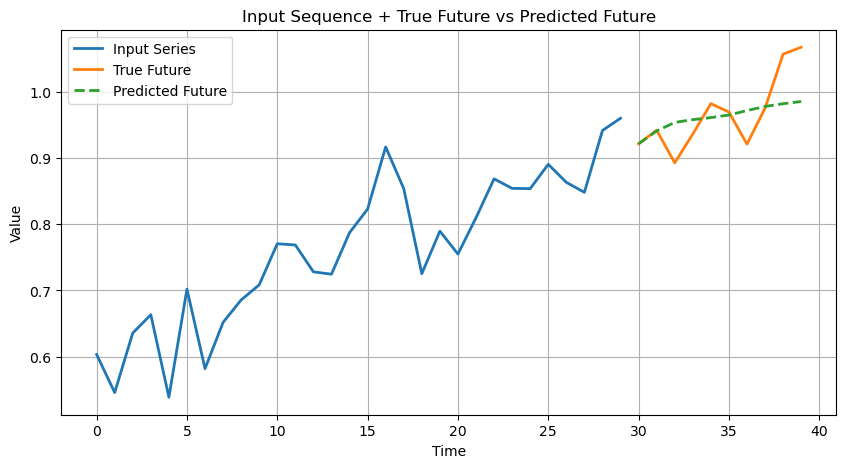

In [17]:
t = np.arange(100)
# series = np.sin(0.1 * t)

input_len = 30
output_len = 10

input_series = X_val[10]
true_future = Y_val[10]
pred_future = model(np.array([input_series]))[0]

plt.figure(figsize=(10, 5))
plt.plot(np.arange(input_len), input_series, label="Input Series", linewidth=2)
plt.plot(np.arange(input_len, input_len + output_len), true_future, label="True Future", linewidth=2)
plt.plot(np.arange(input_len, input_len + output_len), pred_future, label="Predicted Future", linestyle="--", linewidth=2)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Input Sequence + True Future vs Predicted Future")
plt.legend()
plt.grid(True)

plt.show()

In [18]:
pred_future

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.9212492 ],
       [0.94059116],
       [0.9535023 ],
       [0.95770496],
       [0.9607895 ],
       [0.96472156],
       [0.9714288 ],
       [0.97761863],
       [0.98174506],
       [0.9850491 ]], dtype=float32)>

# Modelo

In [19]:
model.layers

[<__main__.Encoder at 0x17dfcc910>, <__main__.Decoder at 0x17dfcdab0>]

In [20]:
encoder = model.layers[0]
decoder = model.layers[1]

In [21]:
emb = encoder(X_val)
emb.shape

TensorShape([19360, 64])

In [22]:
X_val.shape

(19360, 30, 1)